<a href="https://colab.research.google.com/github/nikitha12323/PRODIGY_GA_01/blob/main/PRODIGY_GA_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
import random
from tqdm import tqdm

# ==========================
# Config
# ==========================
DEVICE = "cpu"
IMAGE_SIZE = 256   # use 256x256 as in Pix2Pix paper
BATCH_SIZE = 4
EPOCHS = 5
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================
# Synthetic Paired Dataset
# ==========================
class SyntheticPairedDataset(Dataset):
    def __init__(self, size=200, image_size=256):
        self.size = size
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Input = random noise pattern
        inp = torch.rand(3, self.image_size, self.image_size)
        # Target = blurred version of input
        target = transforms.functional.gaussian_blur(inp, kernel_size=9)
        return {"input": inp, "target": target}

# ==========================
# Generator (U-Net)
# ==========================
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()

        # Encoder block
        def down_block(in_c, out_c, apply_bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
            if apply_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        # Decoder block
        def up_block(in_c, out_c, apply_dropout=False):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            ]
            if apply_dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, features, apply_bn=False)  # 128
        self.down2 = down_block(features, features*2)                   # 64
        self.down3 = down_block(features*2, features*4)                 # 32
        self.down4 = down_block(features*4, features*8)                 # 16
        self.down5 = down_block(features*8, features*8)                 # 8
        self.down6 = down_block(features*8, features*8)                 # 4
        self.down7 = down_block(features*8, features*8)                 # 2
        self.down8 = down_block(features*8, features*8, apply_bn=False) # 1

        self.up1 = up_block(features*8, features*8, apply_dropout=True)
        self.up2 = up_block(features*16, features*8, apply_dropout=True)
        self.up3 = up_block(features*16, features*8, apply_dropout=True)
        self.up4 = up_block(features*16, features*8)
        self.up5 = up_block(features*16, features*4)
        self.up6 = up_block(features*8, features*2)
        self.up7 = up_block(features*4, features)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.down8(d7)

        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final(torch.cat([u7, d1], 1))

# ==========================
# Discriminator (PatchGAN)
# ==========================
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, stride=2, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride, 1, bias=False)]
            if norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels*2, 64, norm=False), # 128
            *block(64, 128),                       # 64
            *block(128, 256),                      # 32
            *block(256, 512, stride=1),            # 31
            nn.Conv2d(512, 1, 4, 1, 1)             # Patch output
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ==========================
# Training
# ==========================
def train():
    # Data
    train_ds = SyntheticPairedDataset(size=100, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    # Models
    gen = UNetGenerator().to(DEVICE)
    disc = PatchGANDiscriminator().to(DEVICE)

    # Losses
    bce = nn.BCEWithLogitsLoss()
    l1 = nn.L1Loss()

    # Optimizers
    opt_g = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

    for epoch in range(1, EPOCHS+1):
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
        for i, batch in enumerate(loop):
            inp, target = batch["input"].to(DEVICE), batch["target"].to(DEVICE)

            # ------------------
            # Train Discriminator
            # ------------------
            fake = gen(inp).detach()
            d_real = disc(inp, target)
            d_fake = disc(inp, fake)

            real_loss = bce(d_real, torch.ones_like(d_real))
            fake_loss = bce(d_fake, torch.zeros_like(d_fake))
            d_loss = (real_loss + fake_loss) / 2

            opt_d.zero_grad()
            d_loss.backward()
            opt_d.step()

            # ------------------
            # Train Generator
            # ------------------
            fake = gen(inp)
            d_fake = disc(inp, fake)
            g_adv = bce(d_fake, torch.ones_like(d_fake))
            g_l1 = l1(fake, target) * 100
            g_loss = g_adv + g_l1

            opt_g.zero_grad()
            g_loss.backward()
            opt_g.step()

            loop.set_postfix({"d_loss": d_loss.item(), "g_loss": g_loss.item()})

        # Save sample outputs
        save_image(fake[:4], os.path.join(OUT_DIR, f"epoch_{epoch}.png"), normalize=True)

    print("Training complete. Samples saved to:", OUT_DIR)


# ==========================
# Run
# ==========================
if __name__ == "__main__":
    print("Device:", DEVICE)
    train()


Device: cpu


Epoch 5/5: 100%|██████████| 25/25 [03:50<00:00,  9.21s/it, d_loss=0.00236, g_loss=16.5]

Training complete. Samples saved to: ./outputs


Saved files: ['epoch_1.png', 'epoch_2.png', 'epoch_3.png', 'epoch_4.png', 'epoch_5.png']


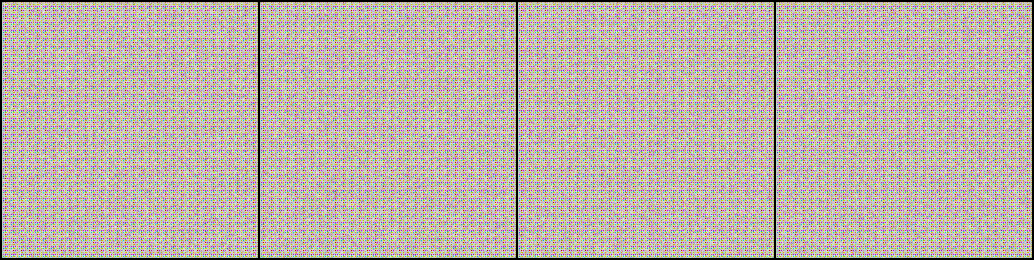

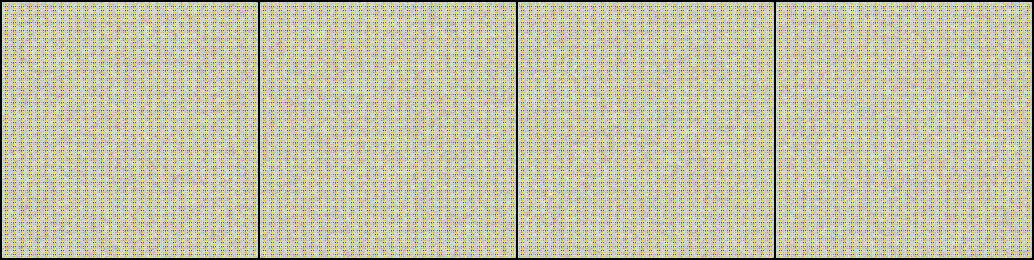

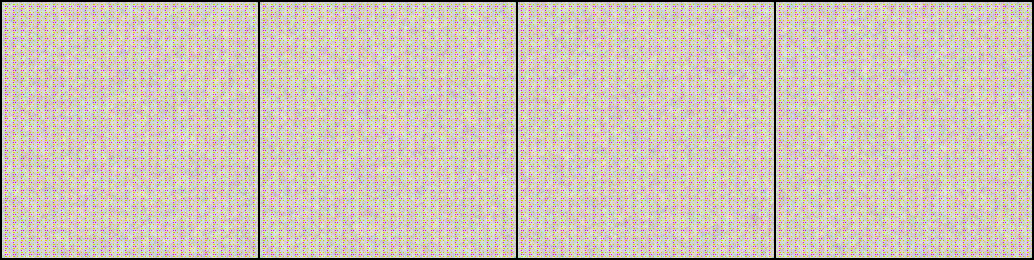

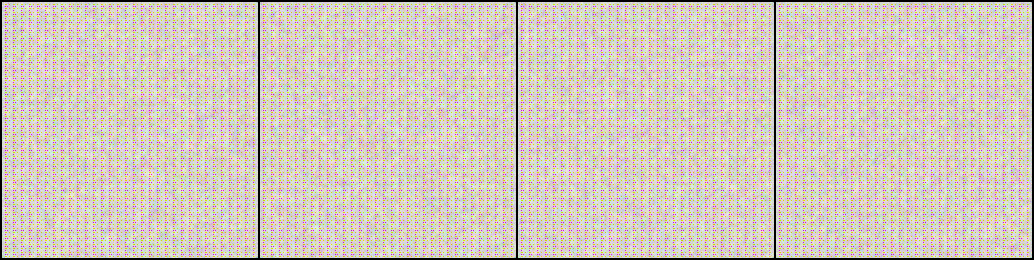

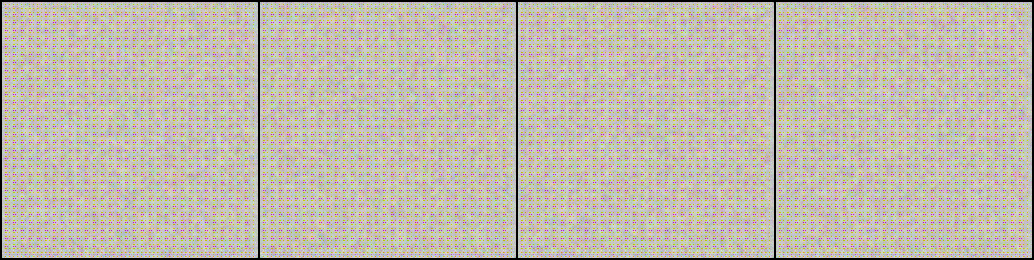

In [ ]:
import os
from IPython.display import Image, display

# List all saved outputs
files = sorted(os.listdir("./outputs"))
print("Saved files:", files)

# Show first 5 samples
for f in files[:5]:
    display(Image(filename=os.path.join("./outputs", f)))
